## **1.1 Importing libraries**

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
import zipfile, io

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Statistical libraries
import scipy.stats as ss
from scipy import stats
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix

# Scikit-learn preprocessing and model selection
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split

# Scikit-learn feature selection
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, RFE, RFECV

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report

# Seaborn settings
sns.set()

# Ignore warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

## **1.2 Importing the datasets**

In [2]:
# extract the project data zip file
z = zipfile.ZipFile('project_data.zip')
z.extractall()

del z

In [3]:
# load the data (train and test)
df_train = pd.read_csv('train_data.csv')
X_test = pd.read_csv('test_data.csv')

In [4]:
df_train.set_index('Claim Identifier', inplace=True)
X_test.set_index('Claim Identifier', inplace=True)

In [5]:
# Do the train val split. Before I also have to drop the target variable from the train data

X_train = df_train.drop(columns=['Claim Injury Type'])
y = df_train['Claim Injury Type']
X_train.drop(columns=['Agreement Reached', 'WCB Decision'], inplace=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)
#### STRATIFY ??????? ####


In [6]:
X_train.shape, y_train.shape

((474776, 29), (474776,))

In [7]:
X_val.shape, y_val.shape

((118695, 29), (118695,))

# 2. Clean and Pre-Process the dataset

In [8]:
# Create copies of the training and test datasets for preprocessing
#X_train = df_train.copy()
#X_test = df_test.copy()

# Note: The test dataset (X_test) does not include 'Agreement Reached', 'WCB Decision', 
# or the target variable 'Claim Injury Type' for prediction

In [9]:
# Drop unnecessary columns from the training dataset
# 'Agreement Reached' and 'WCB Decision' are removed as they are not needed for model training
#X_train.drop(columns=['Agreement Reached', 'WCB Decision'], inplace=True)
#X_val.drop(columns=['Agreement Reached', 'WCB Decision'], inplace=True)

In [10]:
# Check for missing values in the training dataset
X_train.isnull().sum()

Accident Date                          18599
Age at Injury                          15654
Alternative Dispute Resolution         15654
Assembly Date                              0
Attorney/Representative                15654
Average Weekly Wage                    38584
Birth Year                             38926
C-2 Date                               27319
C-3 Date                              324718
Carrier Name                           15654
Carrier Type                           15654
County of Injury                       15654
COVID-19 Indicator                     15654
District Name                          15654
First Hearing Date                    353921
Gender                                 15654
IME-4 Count                           368542
Industry Code                          23625
Industry Code Description              23625
Medical Fee Region                     15654
OIICS Nature of Injury Description    474776
WCIO Cause of Injury Code              28177
WCIO Cause

In [11]:
# Calculate the percentage of missing values in each column of the training dataset
# Only include columns with missing values (x > 0) and sort them in descending order
X_train.isnull().mean().loc[lambda x: x > 0].sort_values(ascending=False) * 100

OIICS Nature of Injury Description    100.000000
IME-4 Count                            77.624396
First Hearing Date                     74.544838
C-3 Date                               68.393937
Birth Year                              8.198814
Zip Code                                8.141945
Average Weekly Wage                     8.126780
WCIO Part Of Body Description           6.176597
WCIO Part Of Body Code                  6.176597
WCIO Nature of Injury Description       5.936694
WCIO Nature of Injury Code              5.936694
WCIO Cause of Injury Description        5.934799
WCIO Cause of Injury Code               5.934799
C-2 Date                                5.754082
Industry Code                           4.976031
Industry Code Description               4.976031
Accident Date                           3.917426
Medical Fee Region                      3.297134
Gender                                  3.297134
Age at Injury                           3.297134
District Name       

- In data analysis, the presence of columns with a high proportion of missing values can harm the quality of results and model performance. Columns with 100%, 77%, or 74% missing values carry little or no useful information for the model, potentially introducing noise and increasing data complexity unnecessarily.

- Eliminating these columns is a common practice to reduce dimensionality and improve data interpretability without significantly compromising the integrity of the analysis.

In [12]:
# Drop columns with high percentages of missing values
# Specifically dropping columns: 'OIICS Nature of Injury Description', 'IME-4 Count', and 'First Hearing Date'
X_train = X_train.drop(columns=['OIICS Nature of Injury Description', 'IME-4 Count', 'First Hearing Date'])
X_val = X_val.drop(columns=['OIICS Nature of Injury Description', 'IME-4 Count', 'First Hearing Date'])
X_test = X_test.drop(columns=['OIICS Nature of Injury Description', 'IME-4 Count', 'First Hearing Date'])

## 2.1. Numerical Data

According to a quick research, Zip Codes in America don't have letters, so this variable can be numerical.

In [13]:
# Extract numeric part of the Zip Code from both training and test datasets
# Using regex to match only digits in the Zip Code (removes any potential non-numeric characters)
X_train['Zip Code'] = X_train['Zip Code'].str.extract('(\d+)')
X_val['Zip Code'] = X_val['Zip Code'].str.extract('(\d+)')

In [14]:
# Convert the Zip Code column to numeric data type in both training and test datasets
# 'errors="coerce"' will set invalid parsing to NaN, handling cases where Zip Code may still have non-numeric characters
X_train['Zip Code'] = pd.to_numeric(X_train['Zip Code'], errors='coerce')
X_val['Zip Code'] = pd.to_numeric(X_val['Zip Code'], errors='coerce')

# display zip code column
X_train['Zip Code'] 

Claim Identifier
6117892    11203.0
5539489    10923.0
6074966    11208.0
5738721        NaN
6133289    14416.0
            ...   
5536601    14020.0
5729342    11950.0
5867607    12078.0
5563633    11520.0
5552082        NaN
Name: Zip Code, Length: 474776, dtype: float64

### 2.1.1. Missing Values

To handle the missing values, different strategies were applied in both the train and test datasets, according to the nature of the variables:
1. Continuous Variables (Age at Injury, Average Weekly Wage):
   - For continuous variables, such as Age at Injury and Average Weekly Wage, missing values were filled with the column mean. This approach is common when the variables are continuous, and it is assumed that the data is approximately symmetrical, meaning the mean adequately represents the central tendency.
2. Discrete Variables (Year of Birth, Industry Code, etc.):
   - For the variable Year of Birth, the mode was used to replace missing values, as this variable is more discrete and represents the birth year, where the median or mean would not be appropriate and could unbalance the data, causing potential issues in the future.
   - Other discrete variables, such as Industry Code and WCIO Cause of Injury Code, were also filled with the mode, which represents the most common value. We believe that the most frequent category is a reasonable substitution for missing values.


In [15]:
# Select only numerical columns in the training dataset
# Store their column names for easier access and processing
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
num_cols

Index(['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents'],
      dtype='object')

In [16]:
# Calculate the number of missing values in each numerical column
X_train[num_cols].isna().sum()

Age at Injury                 15654
Average Weekly Wage           38584
Birth Year                    38926
Industry Code                 23625
WCIO Cause of Injury Code     28177
WCIO Nature of Injury Code    28186
WCIO Part Of Body Code        29325
Zip Code                      50656
Number of Dependents          15654
dtype: int64

In [17]:
# Fill missing values in 'Age at Injury' with the mean value, for both training and test datasets
# Mean is used because it is a continuous variable
injury_age_mean = int(X_train['Age at Injury'].mean()) # using mean because it's a continuous variable
X_train['Age at Injury'].fillna(injury_age_mean, inplace=True)
X_val['Age at Injury'].fillna(injury_age_mean, inplace=True)

# Fill missing values in 'Average Weekly Wage' with the mean value, for both training and test datasets
# Mean is used because it is a continuous variable
avg_w_wage_mean = X_train['Average Weekly Wage'].mean()#.round(2) # using mean because it's a continuous variable
X_train['Average Weekly Wage'].fillna(avg_w_wage_mean, inplace=True)
X_val['Average Weekly Wage'].fillna(avg_w_wage_mean, inplace=True)

In [18]:
# Handle missing values in 'Birth Year'
# Replace 0 values with NaN to avoid using incorrect data, then replace NaN with
X_train['Birth Year'].replace(0, np.nan, inplace=True)
birt_year_mode = X_train['Birth Year'].mode()

# replace in train and test
X_train['Birth Year'].fillna(birt_year_mode, inplace=True)
X_val['Birth Year'].fillna(birt_year_mode, inplace=True)

In [19]:
# Calculate the mode (most frequent value) for each categorical or discrete column
zip_code_mode = X_train['Zip Code'].mode()[0]
cause_code_mode = X_train['WCIO Cause of Injury Code'].mode()[0]
nature_code_mode = X_train['WCIO Nature of Injury Code'].mode()[0]
part_code_mode = X_train['WCIO Part Of Body Code'].mode()[0]
industry_code_mode = X_train['Industry Code'].mode()[0]
dependents_mode = X_train['Number of Dependents'].mode()[0]

# Fill missing values in the training dataset with the mode for each respective column
X_train['Zip Code'].fillna(zip_code_mode, inplace=True)
X_train['WCIO Cause of Injury Code'].fillna(cause_code_mode, inplace=True)
X_train['WCIO Nature of Injury Code'].fillna(nature_code_mode, inplace=True)
X_train['WCIO Part Of Body Code'].fillna(part_code_mode, inplace=True)
X_train['Industry Code'].fillna(industry_code_mode, inplace=True)
X_train['Number of Dependents'].fillna(dependents_mode, inplace=True)

# Repeat the same imputation process for the test dataset using the modes calculated from the training dataset
X_val['Zip Code'].fillna(zip_code_mode, inplace=True)
X_val['WCIO Cause of Injury Code'].fillna(cause_code_mode, inplace=True)
X_val['WCIO Nature of Injury Code'].fillna(nature_code_mode, inplace=True)
X_val['WCIO Part Of Body Code'].fillna(part_code_mode, inplace=True)
X_val['Industry Code'].fillna(industry_code_mode, inplace=True)
X_val['Number of Dependents'].fillna(dependents_mode, inplace=True)


In [20]:
# Fill missing values in 'Birth Year' with the median value
# Median is used here as a more robust measure for this continuous variable
birth_year_median = X_train['Birth Year'].median()
X_train['Birth Year'].fillna(birth_year_median, inplace=True)
X_val['Birth Year'].fillna(birth_year_median, inplace=True)

In [21]:
# Check if there are any remaining missing values in numerical columns
X_train[num_cols].isna().sum() #rechecking missing values

Age at Injury                 0
Average Weekly Wage           0
Birth Year                    0
Industry Code                 0
WCIO Cause of Injury Code     0
WCIO Nature of Injury Code    0
WCIO Part Of Body Code        0
Zip Code                      0
Number of Dependents          0
dtype: int64

In [22]:
X_val[num_cols].isna().sum() #rechecking missing values

Age at Injury                 0
Average Weekly Wage           0
Birth Year                    0
Industry Code                 0
WCIO Cause of Injury Code     0
WCIO Nature of Injury Code    0
WCIO Part Of Body Code        0
Zip Code                      0
Number of Dependents          0
dtype: int64

### 2.1.2. Outliers

Outlier Removal and Treatment
Each variable was treated according to the data type and reasonable limits to avoid distortions, and these changes were applied to both datasets.
1. Age at Injury:
   - An acceptable range for Age at Injury was defined between 14 and 66 years, based on labor regulations that set minimum and maximum working ages. Values outside this range were considered outliers and were removed.
2. Year of Birth:
   - A range for Year of Birth was set between 1955 and 2004, assuming a reasonable age range for workers. Data outside this range was considered atypical and removed to maintain consistency.
3. Average Weekly Wage:
   - For Average Weekly Wage, the Interquartile Range (IQR) technique was used to define lower and upper limits based on the quartiles (Q1 and Q3) and the formula IQR = Q3 - Q1. Any value outside the range was considered an outlier. Instead of removing these values, a capping technique was applied, limiting the values to the upper and lower bounds of the IQR, which allows data preservation by adjusting outliers to an acceptable value without losing them.
 
3. Specific Numerical Values Treatment
Zip Code
The postal code (Zip Code) was transformed to ensure it was numeric and contained only valid values:
- First, the numeric part of the postal code was extracted, removing any non-numeric characters that might be present.
- Then, postal codes were converted to a numeric type, with the errors=coerce setting to replace invalid values with NaN, ensuring an initial data cleanup.
- Subsequently, a filter was applied to remove postal codes with fewer than 5 digits, retaining only those that follow the expected pattern for US postal codes.


In [23]:
# Check the distribution and summary statistics for numerical columns to identify possible outliers
X_train.describe()

,Age at Injury,Average Weekly Wage,Birth Year,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Number of Dependents
count,474776.000000,4.747760e+05,474776.000000,474776.000000,474776.000000,474776.000000,474776.000000,474776.000000,474776.000000
mean,42.123081,4.907516e+02,1977.808339,58.823428,54.489955,41.660985,39.872763,12358.712806,3.104340
std,14.023633,6.182535e+03,12.949761,19.156416,25.078545,21.705560,21.679693,5117.876357,2.039322
min,0.000000,0.000000e+00,1900.000000,11.000000,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,31.000000,0.000000e+00,1968.000000,45.000000,31.000000,25.000000,33.000000,11212.000000,1.000000
50%,42.000000,0.000000e+00,1978.000000,61.000000,56.000000,49.000000,41.000000,11554.000000,3.000000
75%,53.000000,7.606450e+02,1988.000000,62.000000,75.000000,52.000000,53.000000,13021.000000,5.000000
max,117.000000,2.828079e+06,2018.000000,92.000000,99.000000,91.000000,99.000000,99999.000000,6.000000


**Age at Injury**

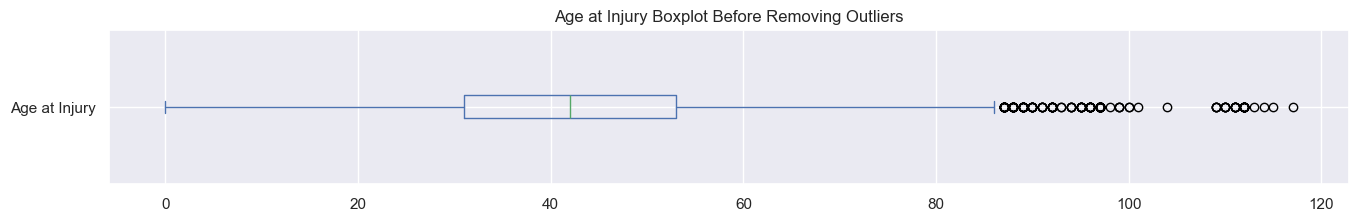

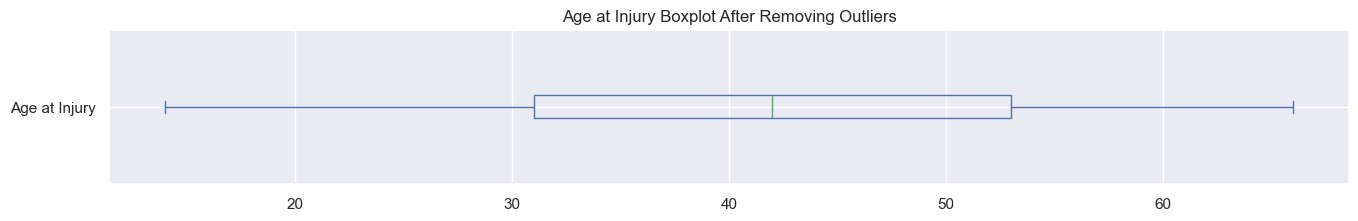

In [24]:
# Initial boxplot to visualize outliers in 'Age at Injury'
X_train['Age at Injury'].plot(kind='box', vert=False, figsize=(16, 2))
plt.title('Age at Injury Boxplot Before Removing Outliers')
plt.show()

# Filter out outliers in 'Age at Injury' by retaining only values between 14 and 66
# Ages below 14 and above 66 are considered unlikely for workplace injuries according to U.S. labor regulations

X_train = X_train[(X_train['Age at Injury'] >= 14) & (X_train['Age at Injury'] <= 66)]
X_val = X_val[(X_val['Age at Injury'] >= 14) & (X_val['Age at Injury'] <= 66)]

# remove the same instances from the target variable, because both need to have the same shape for RFE Logistic Regression (for example)
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

# Boxplot for 'Age at Injury' after removing outliers to verify the change
X_train['Age at Injury'].plot(kind='box', vert=False, figsize=(16, 2))
plt.title('Age at Injury Boxplot After Removing Outliers')
plt.show()


**Birth Year**

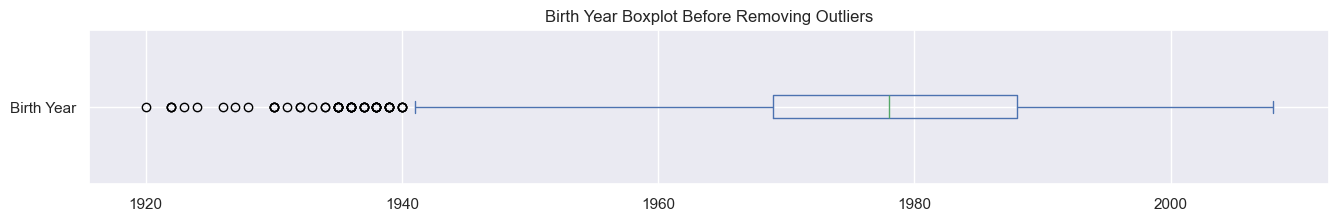

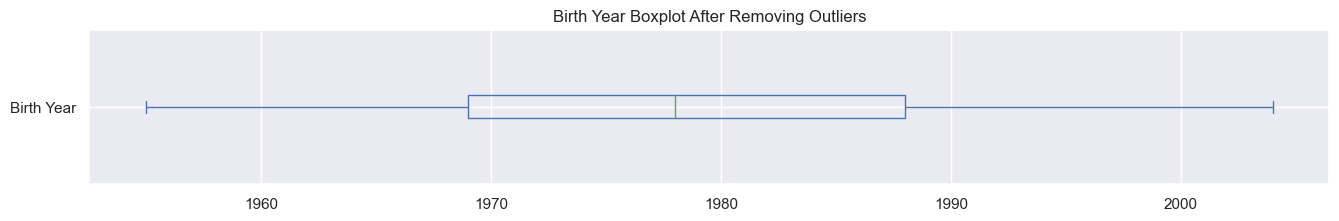

In [25]:
# Initial boxplot to visualize outliers in 'Birth Year'
X_train['Birth Year'].plot(kind='box', vert=False, figsize=(16, 2))
plt.title('Birth Year Boxplot Before Removing Outliers')
plt.show()

# Define the valid range for 'Birth Year' based on the dataset's collection period (2020 to 2022)
# Assuming a working age range, birth years are expected to be between 1955 and 2004

X_train = X_train[(X_train['Birth Year'] >= 1955) & (X_train['Birth Year'] <= 2004)]
X_val = X_val[(X_val['Birth Year'] >= 1955) & (X_val['Birth Year'] <= 2004)]

# remove the same instances from the target variable, because both need to have the same shape for RFE Logistic Regression (for example)
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

# Boxplot for 'Birth Year' after removing outliers to verify the change
X_train['Birth Year'].plot(kind='box', vert=False, figsize=(16, 2))
plt.title('Birth Year Boxplot After Removing Outliers')
plt.show()

**Average Weekly Wage**

In [26]:
# Calculate the first and third quartiles (Q1 and Q3) for 'Average Weekly Wage'
Q1 = X_train['Average Weekly Wage'].quantile(0.25)
Q3 = X_train['Average Weekly Wage'].quantile(0.75)
IQR = Q3 - Q1

# Determine the lower and upper bounds for outliers using the IQR
# Any values outside these bounds are considered outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers in 'Average Weekly Wage' based on the defined bounds
outliers = X_train[(X_train['Average Weekly Wage'] < lower_bound) | (X_train['Average Weekly Wage'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
outliers[['Average Weekly Wage']].head()


Number of outliers: 22504


,Average Weekly Wage
Claim Identifier,
5499295,2489.20
6086293,2187.50
6085709,2066.90
5993318,2362.12
6088960,1998.92


In [27]:
# Limit the values in 'Average Weekly Wage' to the IQR bounds by capping
# Values below lower_bound are set to lower_bound, and those above upper_bound are set to upper_bound
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].clip(lower=lower_bound, upper=upper_bound)
X_val['Average Weekly Wage'] = X_val['Average Weekly Wage'].clip(lower=lower_bound, upper=upper_bound)


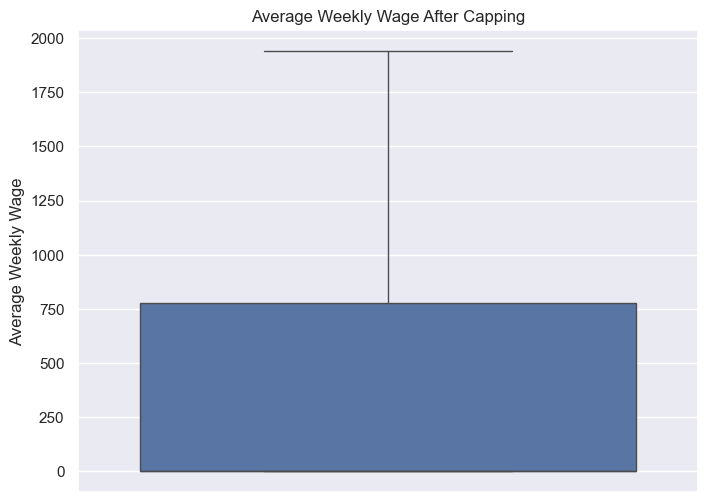

In [28]:
# Boxplot to verify the distribution of 'Average Weekly Wage' after capping
plt.figure(figsize=(8, 6))
sns.boxplot(data=X_train, y='Average Weekly Wage')
plt.title('Average Weekly Wage After Capping')
plt.show()


**Zip Code**

In [29]:
X_train['Zip Code'] = X_train['Zip Code'].astype(int)
X_val['Zip Code'] = X_val['Zip Code'].astype(int)

In [30]:
# zip codes can only have 5 digits, let's remove those that haven't

# create a function to count the number of digits
def count_digit(x):
    count = 0
    for i in x:
        if i.isdigit():
            count += 1
    return count

# get zip codes with less or more than 5 digits using the function created
zip_outliers = X_train[X_train['Zip Code'].apply(lambda x: count_digit(str(x)) != 5)]

# remove zip outliers from X_train
X_train = X_train[~X_train['Zip Code'].isin(zip_outliers['Zip Code'])]
X_val = X_val[~X_val['Zip Code'].isin(zip_outliers['Zip Code'])]

# remove the same instances from the target variable, because both need to have the same shape for RFE Logistic Regression (for example)
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

The remaining variables are codes, therefore, they must be checked with the documentation in order to discover wrong codes.

We have left it for future work for the time being. Deferring code validation allows us to concentrate on high-priority data issues first, optimizing resources and preventing redundancies. The clean and accurate results it allows mean eventual coding errors are easier to debug, informed by patterns identified in initial analyses.

## 2.2 Categorical Data

In [31]:
cat_cols = X_train.select_dtypes(exclude=['float64', 'int64']).columns
cat_cols

Index(['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date',
       'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name',
       'Carrier Type', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'Gender', 'Industry Code Description',
       'Medical Fee Region', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Description'],
      dtype='object')

### Missing Values

In [32]:
X_train[cat_cols].isna().sum()

Accident Date                         15654
Alternative Dispute Resolution        15654
Assembly Date                             0
Attorney/Representative               15654
C-2 Date                              24519
C-3 Date                             303880
Carrier Name                          15654
Carrier Type                          15654
County of Injury                      15654
COVID-19 Indicator                    15654
District Name                         15654
Gender                                15654
Industry Code Description             21827
Medical Fee Region                    15654
WCIO Cause of Injury Description      25165
WCIO Nature of Injury Description     25172
WCIO Part Of Body Description         26026
dtype: int64

Lets start by watching missing values in the target variable. Those observations should be dropped

In [33]:
# Check the missing values in the target variable Claim Injury Type
print(f"Missing values in y_train: {y_train.isna().sum()}")
print(f"Missing values in y_val: {y_val.isna().sum()}")

Missing values in y_train: 15654
Missing values in y_val: 3791


In [34]:
# get the indexes of the missing values in the target variable Claim Injury Type
missing_y_train = y_train[y_train.isna()].index
missing_y_val = y_val[y_val.isna()].index

# drop the missing values from the target variable Claim Injury Type
y_train.drop(index=missing_y_train, inplace=True)
y_val.drop(index=missing_y_val, inplace=True)

# drop the same indexes from the X_train and X_val
X_train.drop(index=missing_y_train, inplace=True)
X_val.drop(index=missing_y_val, inplace=True)

In [35]:
y_train.isna().sum(), y_val.isna().sum()

(0, 0)

### **2.2.1. Accident Date**

* Our initial observation was that there were missing values for the accident date, so we decided to fill them in with C-2 and C-3. The underlying logic is that these values normally correspond closely to the Accident Date, so accuracy is maintained. 
* However, since these two also had many missing values, when the data remains unavailable we decided to use the Date of Assembly minus the average offset (typical time difference) between the Date of Assembly and the Date of Accident. Through this process we aim to maintain the highest date accuracy based on the knowledge that the other dates we observed generally did not differ much from the Accident Date.


In [36]:
missing_values_train = X_train["Accident Date"].isna().sum()
missing_values_test = X_val["Accident Date"].isna().sum()

In [37]:
print(f"Missing values in 'Accident Date' before handling (X_train): {missing_values_train}")
print(f"Missing values in 'Accident Date' before handling (X_val): {missing_values_test}")

Missing values in 'Accident Date' before handling (X_train): 0
Missing values in 'Accident Date' before handling (X_val): 0


In [38]:
# Ensure date columns are in datetime format
X_train['Accident Date'] = pd.to_datetime(X_train['Accident Date'], errors='coerce')
X_train['Assembly Date'] = pd.to_datetime(X_train['Assembly Date'], errors='coerce')
X_train['C-2 Date'] = pd.to_datetime(X_train['C-2 Date'], errors='coerce')
X_train['C-3 Date'] = pd.to_datetime(X_train['C-3 Date'], errors='coerce')

X_val['Accident Date'] = pd.to_datetime(X_val['Accident Date'], errors='coerce')
X_val['Assembly Date'] = pd.to_datetime(X_val['Assembly Date'], errors='coerce')
X_val['C-2 Date'] = pd.to_datetime(X_val['C-2 Date'], errors='coerce')
X_val['C-3 Date'] = pd.to_datetime(X_val['C-3 Date'], errors='coerce')


# Try to fill missing 'Accident Date' with 'C-2 Date' or 'C-3 Date'
X_train['Accident Date'] = X_train['Accident Date'].fillna(X_train['C-2 Date']).fillna(X_train['C-3 Date'])
X_val['Accident Date'] = X_val['Accident Date'].fillna(X_val['C-2 Date']).fillna(X_val['C-3 Date'])

# Calculate the median offset between 'Accident Date' and 'Assembly Date'
avg_offset = (X_train['Assembly Date'] - X_train['Accident Date']).median()

# Fill missing 'Accident Date' with 'Assembly Date' minus the average offset
X_train['Accident Date'] = X_train['Accident Date'].fillna(X_train['Assembly Date'] - avg_offset)
X_val['Accident Date'] = X_val['Accident Date'].fillna(X_val['Assembly Date'] - avg_offset)

# Check if there are still missing values after this handling
missing_values_train = X_train["Accident Date"].isna().sum()
missing_values_test = X_val["Accident Date"].isna().sum()

print(f"Missing values in 'Accident Date' after handling (X_train): {missing_values_train}")
print(f"Missing values in 'Accident Date' after handling (X_val): {missing_values_test}")


Missing values in 'Accident Date' after handling (X_train): 0
Missing values in 'Accident Date' after handling (X_val): 0


We're also dropping the date column and keep a column for the accident year, one for accident month, and one called accident on weekday.

In [39]:
X_train['Accident Year'] = X_train['Accident Date'].dt.year
X_train['Accident Month'] = X_train['Accident Date'].dt.month
X_train['Accident on Weekday'] = X_train['Accident Date'].dt.dayofweek < 5

X_val['Accident Year'] = X_val['Accident Date'].dt.year
X_val['Accident Month'] = X_val['Accident Date'].dt.month
X_val['Accident on Weekday'] = X_val['Accident Date'].dt.dayofweek < 5

# Make accident date datetime on test set
X_test['Accident Date'] = pd.to_datetime(X_test['Accident Date'], errors='coerce')
# IS THIS CORRECT? SHOULD WE DO THIS? WE NEED IT IN ORDER TO RUN, BUT IS IT A GOOD APROACH SINCE WE'RE TOUCHING ON TEST SET?

X_test['Accident Year'] = X_test['Accident Date'].dt.year
X_test['Accident Month'] = X_test['Accident Date'].dt.month
X_test['Accident on Weekday'] = X_test['Accident Date'].dt.dayofweek < 5



Dropping the Accident Date column

### **2.2.2 Alternative Dispute Resolution**

* Regarding the execution of Alternative Dispute Resolutions, it did not occur for more than 95% of the dataset entries. Due to the high class imbalance of this feature, it will most likely not have a significant influence on the target variable, so the model will not learn much from it.

In [40]:
X_train['Alternative Dispute Resolution'].describe()

count     425031
unique         3
top            N
freq      423271
Name: Alternative Dispute Resolution, dtype: object

In [41]:
# Calculate the mode of 'Alternative Dispute Resolution' from X_train to fill missing data
adr_mode = X_train["Alternative Dispute Resolution"].mode()[0]

# Replace "U" directly with the mode in both training and test sets
X_train["Alternative Dispute Resolution"].replace("U", adr_mode, inplace=True)
X_train["Alternative Dispute Resolution"].fillna(adr_mode, inplace=True)  # Fill any remaining missing values
X_val["Alternative Dispute Resolution"].replace("U", adr_mode, inplace=True)
X_val["Alternative Dispute Resolution"].fillna(adr_mode, inplace=True)  # Fill any remaining missing values

# Convert "Y" to 1 and "N" to 0 for binary representation in both sets
X_train["Alternative Dispute Resolution"] = X_train["Alternative Dispute Resolution"].map({"Y": 1, "N": 0})
X_val["Alternative Dispute Resolution"] = X_val["Alternative Dispute Resolution"].map({"Y": 1, "N": 0})
X_test["Alternative Dispute Resolution"] = X_test["Alternative Dispute Resolution"].map({"Y": 1, "N": 0})

### **2.2.3 Attorney/Representative**

* The Distribution of the existence of an Attorney / Representative provides enough cases of each binary option for the model to be potentially able to learn useful knowledge to predict the target dependent variable.

In [42]:
#Check for missing values in Attorney/Representative

missing_values_train = X_train["Attorney/Representative"].isna().sum()
missing_values_test = X_val["Attorney/Representative"].isna().sum()

print(f"Missing values in 'Attorney/Representative' before handling (X_train): {missing_values_train}")
print(f"Missing values in 'Attorney/Representative' before handling (X_val): {missing_values_test}")

Missing values in 'Attorney/Representative' before handling (X_train): 0
Missing values in 'Attorney/Representative' before handling (X_val): 0


In [43]:
# Calculate the proportion of "Y" and "N" in X_train for Attorney/Representative
proportion_Y = X_train['Attorney/Representative'].value_counts(normalize=True)["Y"]
proportion_N = X_train['Attorney/Representative'].value_counts(normalize=True)["N"]

# Fill missing values in X_train based on the calculated proportions
X_train['Attorney/Representative'] = X_train['Attorney/Representative'].apply(
    lambda x: np.random.choice(["Y", "N"], p=[proportion_Y, proportion_N]) if pd.isna(x) else x
)

# Repeat the same filling process for X_val
X_val['Attorney/Representative'] = X_val['Attorney/Representative'].apply(
    lambda x: np.random.choice(["Y", "N"], p=[proportion_Y, proportion_N]) if pd.isna(x) else x
)

# Convert "Y" to 1 and "N" to 0 for binary representation in both sets
X_train['Attorney/Representative'] = X_train['Attorney/Representative'].map({"Y": 1, "N": 0})
X_val['Attorney/Representative'] = X_val['Attorney/Representative'].map({"Y": 1, "N": 0})
X_test['Attorney/Representative'] = X_test['Attorney/Representative'].map({"Y": 1, "N": 0})


### **2.2.4 C-2 Date C-3 Date**

* Many values are missing in both C-2 and C-3, but before making decisions on how to deal with them we decided to analyze the time intervals between the date of the accident and these dates to find out if there were any inconsistencies. 

* As a result, we found that many of the time intervals gave negative values (which is not possible since those dates cannot be prior to the accident). With this in mind, we decided to remove the rows that showed such inconsistencies. Next, we continued to visualize the remaining data and discovered that the date range was really high, probably showing extreme outliers. Therefore, we conducted some research on IUS law and discovered that the time period for filing a post-accident injury claim, known as the statute of limitations, varies by state and type of claim. In general, the statute of limitations for personal injury claims ranges from 1 to 6 years in different states, so we set a threshold of 2190 days or 6 years.

* Our last step was to binarize those two dates: 1 if a date-time existed and 0 if it was missing. 


In [44]:
X_train['Accident_C2_Diff'] = (X_train['C-2 Date'] - X_train['Accident Date']).dt.days
X_train['Accident_C3_Diff'] = (X_train['C-3 Date'] - X_train['Accident Date']).dt.days

X_val['Accident_C2_Diff'] = (X_val['C-2 Date'] - X_val['Accident Date']).dt.days
X_val['Accident_C3_Diff'] = (X_val['C-3 Date'] - X_val['Accident Date']).dt.days


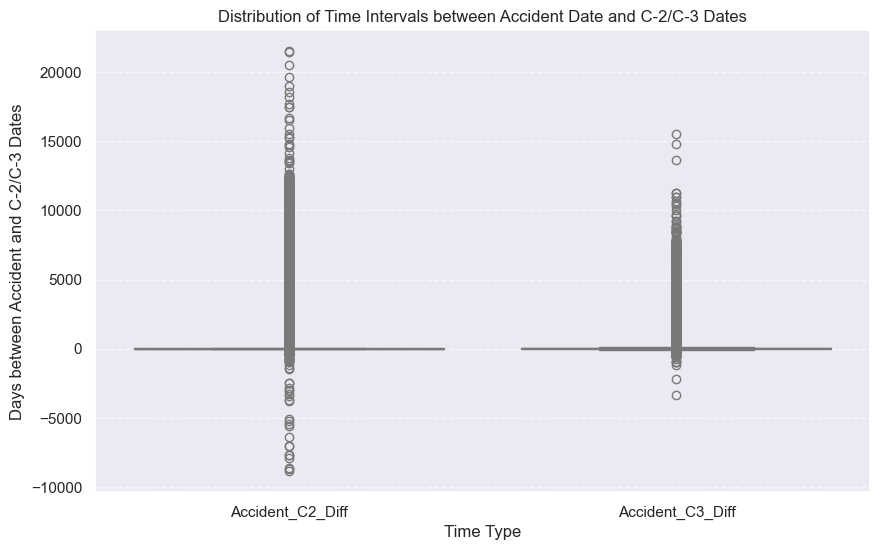

In [45]:
# Checking the initial distribution of 'Accident_C2_Diff' and 'Accident_C3_Diff'
# Prepare data for plotting by melting into long format
time_data = X_train[['Accident_C2_Diff', 'Accident_C3_Diff']].melt(var_name="Time Type", value_name="Days")

# Create the boxplot for 'Accident_C2_Diff' and 'Accident_C3_Diff'
plt.figure(figsize=(10, 6))
sns.boxplot(data=time_data, x="Time Type", y="Days", palette="coolwarm")


plt.title("Distribution of Time Intervals between Accident Date and C-2/C-3 Dates")
plt.xlabel("Time Type")
plt.ylabel("Days between Accident and C-2/C-3 Dates")

# Display the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [46]:
# Convert 'Accident Date', 'C-2 Date', and 'C-3 Date' to datetime format

X_train['C-2 Date'] = pd.to_datetime(X_train['C-2 Date'], errors='coerce')
X_train['C-3 Date'] = pd.to_datetime(X_train['C-3 Date'], errors='coerce')

X_val['C-2 Date'] = pd.to_datetime(X_val['C-2 Date'], errors='coerce')
X_val['C-3 Date'] = pd.to_datetime(X_val['C-3 Date'], errors='coerce')

# Calculate the time intervals
time_to_c2_train = (X_train['C-2 Date'] - X_train['Accident Date']).dt.days
time_to_c3_train = (X_train['C-3 Date'] - X_train['Accident Date']).dt.days

time_to_c2_test = (X_val['C-2 Date'] - X_val['Accident Date']).dt.days
time_to_c3_test = (X_val['C-3 Date'] - X_val['Accident Date']).dt.days

# Print the number of rows with negative intervals
print(f"Number of rows with negative intervals in training set: {((time_to_c2_train < 0) | (time_to_c3_train < 0)).sum()}")
print(f"Number of rows with negative intervals in test set: {((time_to_c2_test < 0) | (time_to_c3_test < 0)).sum()}")

# Drop rows with negative intervals, keeping rows with NaN values
X_train = X_train[((time_to_c2_train >= 0) | (time_to_c2_train.isna())) & ((time_to_c3_train >= 0) | (time_to_c3_train.isna()))]
X_val = X_val[((time_to_c2_test >= 0) | (time_to_c2_test.isna())) & ((time_to_c3_test >= 0) | (time_to_c3_test.isna()))]

# remove the same instances from the target variable, because both need to have the same shape for RFE Logistic Regression (for example)
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

Number of rows with negative intervals in training set: 1267
Number of rows with negative intervals in test set: 281


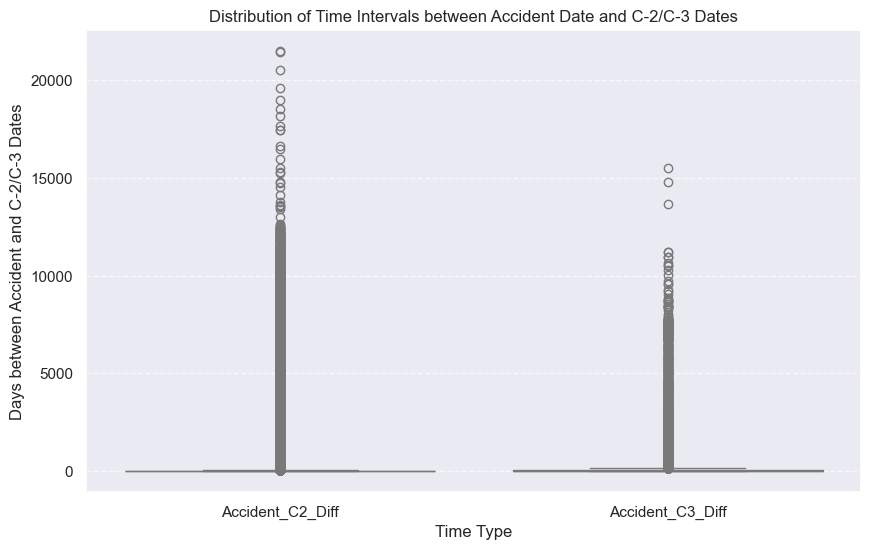

In [47]:
#Checking the distribution after last cell filetering to check that there are no negative values
time_data = X_train[['Accident_C2_Diff', 'Accident_C3_Diff']].melt(var_name="Time Type", value_name="Days")

# Create the boxplot for 'Accident_C2_Diff' and 'Accident_C3_Diff' on the same graph with coolwarm palette
plt.figure(figsize=(10, 6))
sns.boxplot(data=time_data, x="Time Type", y="Days", palette="coolwarm")

# Titles and labels
plt.title("Distribution of Time Intervals between Accident Date and C-2/C-3 Dates")
plt.xlabel("Time Type")
plt.ylabel("Days between Accident and C-2/C-3 Dates")

# Display the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In the United States, the time limit to file an injury claim after an accident, known as the statute of limitations, varies by state and type of claim. Generally, the limitation period for personal injury claims ranges from 1 to 6 years across different states.

In [48]:
# Ensure 'C-2 Date', and 'C-3 Date' are in datetime format
X_train['C-2 Date'] = pd.to_datetime(X_train['C-2 Date'], errors='coerce')
X_train['C-3 Date'] = pd.to_datetime(X_train['C-3 Date'], errors='coerce')

X_val['C-2 Date'] = pd.to_datetime(X_val['C-2 Date'], errors='coerce')
X_val['C-3 Date'] = pd.to_datetime(X_val['C-3 Date'], errors='coerce')

# Calculate the time differences (in days) between 'Accident Date' and 'C-2 Date' / 'C-3 Date'
X_train['Accident_C2_Diff'] = (X_train['C-2 Date'] - X_train['Accident Date']).dt.days
X_train['Accident_C3_Diff'] = (X_train['C-3 Date'] - X_train['Accident Date']).dt.days

X_val['Accident_C2_Diff'] = (X_val['C-2 Date'] - X_val['Accident Date']).dt.days
X_val['Accident_C3_Diff'] = (X_val['C-3 Date'] - X_val['Accident Date']).dt.days

# Define the threshold for time. We set 6 years and expalined in the markdown above
time_threshold = 2190  # 6 years in days

# Check the number of rows exceeding the threshold for each interval. Just to check if our conditions are set up correctly
print(f"Number of rows exceeding threshold in Accident_C2_Diff (X_train): {(X_train['Accident_C2_Diff'] > time_threshold).sum()}")
print(f"Number of rows exceeding threshold in Accident_C3_Diff (X_train): {(X_train['Accident_C3_Diff'] > time_threshold).sum()}")

print(f"Number of rows exceeding threshold in Accident_C2_Diff (X_val): {(X_val['Accident_C2_Diff'] > time_threshold).sum()}")
print(f"Number of rows exceeding threshold in Accident_C3_Diff (X_val): {(X_val['Accident_C3_Diff'] > time_threshold).sum()}")

# Drop rows with time intervals exceeding the threshold, keeping rows with NaN values
X_train = X_train[((X_train['Accident_C2_Diff'] <= time_threshold) | (X_train['Accident_C2_Diff'].isna())) &
                  ((X_train['Accident_C3_Diff'] <= time_threshold) | (X_train['Accident_C3_Diff'].isna()))]

X_val = X_val[((X_val['Accident_C2_Diff'] <= time_threshold) | (X_val['Accident_C2_Diff'].isna())) &
                ((X_val['Accident_C3_Diff'] <= time_threshold) | (X_val['Accident_C3_Diff'].isna()))]

# remove the same instances from the target variable, because both need to have the same shape for RFE Logistic Regression (for example)
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]


Number of rows exceeding threshold in Accident_C2_Diff (X_train): 1703
Number of rows exceeding threshold in Accident_C3_Diff (X_train): 507
Number of rows exceeding threshold in Accident_C2_Diff (X_val): 346
Number of rows exceeding threshold in Accident_C3_Diff (X_val): 95


In [49]:
#Now we're creating a new column to indicate if the date was imputed or not
X_train['C-2 Date'] = X_train['C-2 Date'].isna().astype(int)
X_train['C-3 Date'] = X_train['C-3 Date'].isna().astype(int)

X_val['C-2 Date'] = X_val['C-2 Date'].isna().astype(int)
X_val['C-3 Date'] = X_val['C-3 Date'].isna().astype(int)

X_test['C-2 Date'] = X_test['C-2 Date'].isna().astype(int)
X_test['C-3 Date'] = X_test['C-3 Date'].isna().astype(int)

In [50]:
#Drop the features created to help visualize the data

X_train.drop(columns=['Accident_C2_Diff', 'Accident_C3_Diff'], inplace=True)
X_val.drop(columns=['Accident_C2_Diff', 'Accident_C3_Diff'], inplace=True)

### **2.2.5 Carrier Name**

* After performing the data cleaning process described above, we did not find any missing values for either Carrier Name, Carrier Type, or Accident County. 

Note: however, when examining our dataset model, we observed that some text entries for Carrier Name had inconsistencies that caused the inaccuracy of the unique values. In the next phase we will apply the fuzzy machine technique to solve this problem which will hopefully result in a better predictive model.


In [51]:
# Display the result to confirm it's 0
print("Missing values in X_train after replacement:", X_train['Carrier Name'].isna().sum())
print("Missing values in X_val after replacement:", X_val['Carrier Name'].isna().sum())


Missing values in X_train after replacement: 0
Missing values in X_val after replacement: 0


In the next handout we need to fix this feature. We found a lot of carrier names that were very simillar but were written in different ways. We need to fix this in order to reduce the cardinality of this feature.

### **2.2.6 Carrier Type**

In [52]:
# Display the result to confirm it's 0
print("Missing values in X_train after replacement:", X_train['Carrier Type'].isna().sum())
print("Missing values in X_val after replacement:", X_val['Carrier Type'].isna().sum())


Missing values in X_train after replacement: 0
Missing values in X_val after replacement: 0


### **2.2.7 County of Injury**

In [53]:
# Calculate the mode of 'County of Injury' column in X_train
county_injury_mode = X_train['County of Injury'].mode()[0]

# Replace missing values in 'County of Injury' with the mode in both X_train and X_val
X_train['County of Injury'].fillna(county_injury_mode, inplace=True)
X_val['County of Injury'].fillna(county_injury_mode, inplace=True)

# Display the result to confirm
print("Missing values in X_train after replacement:", X_train['County of Injury'].isna().sum())
print("Missing values in X_val after replacement:", X_val['County of Injury'].isna().sum())


Missing values in X_train after replacement: 0
Missing values in X_val after replacement: 0


### **2.2.8 Covid-19**

* We defined a function to check for missing values. If there were, we used the missing values approach based on the most common indicators for each “WCIO Nature of Injury Description” and “WCIO Cause of Injury Description”. We wanted to find the most likely indicator value for any injury or cause. 
* Finally, we converted the COVID/19 indicator to binary, where Y corresponds to 1 and N to 0, to ensure consistency of format for modeling.  
* This method ensures that the values are filled in logically based on common patterns of other feature combinations, which increases the reliability of the model.


In [54]:
# Create a mapping of the most common 'Covid-19 Indicator' for each combination of injury and cause
covid_mapping = X_train.groupby(['WCIO Nature of Injury Description', 'WCIO Cause of Injury Description'])['COVID-19 Indicator'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)

# Define a function to fill missing 'Covid-19 Indicator' based on the mapping
def fill_covid_indicator(row):
    if pd.isna(row['COVID-19 Indicator']):
        return covid_mapping.get((row['WCIO Nature of Injury Description'], row['WCIO Cause of Injury Description']), row['COVID-19 Indicator'])
    else:
        return row['COVID-19 Indicator']

# Apply the function to fill missing values
X_train['COVID-19 Indicator'] = X_train.apply(fill_covid_indicator, axis=1)
X_val['COVID-19 Indicator'] = X_val.apply(fill_covid_indicator, axis=1)


In [55]:
# Convert 'COVID-19 Indicator' to binary: 1 for "Yes" and 0 for "No"
X_train['COVID-19 Indicator'] = X_train['COVID-19 Indicator'].map({"Y": 1, "N": 0})
X_val['COVID-19 Indicator'] = X_val['COVID-19 Indicator'].map({"Y": 1, "N": 0})
X_test['COVID-19 Indicator'] = X_test['COVID-19 Indicator'].map({"Y": 1, "N": 0})

# Print number of missing values after handling
print("Missing values in X_train after replacement:", X_train['COVID-19 Indicator'].isna().sum())
print("Missing values in X_val after replacement:", X_val['COVID-19 Indicator'].isna().sum())

Missing values in X_train after replacement: 0
Missing values in X_val after replacement: 0


### **2.2.9 Assembly Date**

There were no missing values for this feature. However, applying logic and reasoning, we decided to eliminate all rows where the assembly date was prior to the date of the accident.

In [56]:
# Calculate the number of rows before dropping
rows_before_train = X_train.shape[0]
rows_before_test = X_val.shape[0]


# Drop rows where 'Assembly Date' is before 'Accident Date'

X_train = X_train[X_train['Assembly Date'] >= X_train['Accident Date']]

X_train['Assembly Date'] = pd.to_datetime(X_train['Assembly Date'], errors='coerce')
X_val['Assembly Date'] = pd.to_datetime(X_val['Assembly Date'], errors='coerce')
                  
# Calculate the number of rows after dropping
rows_after_train = X_train.shape[0]
rows_after_test = X_val.shape[0]

# Print the difference in row count

print(f"Number of rows dropped on train: {rows_before_train - rows_after_test}")
print(f"Number of rows dropped on validation: {rows_before_train - rows_after_test}")


Number of rows dropped on train: 319683
Number of rows dropped on validation: 319683


In [57]:
#Create new columns for the year and month of the Assembly Date

X_train['Assembly Year'] = X_train['Assembly Date'].dt.year
X_train['Assembly Month'] = X_train['Assembly Date'].dt.month

X_val['Assembly Year'] = X_val['Assembly Date'].dt.year
X_val['Assembly Month'] = X_val['Assembly Date'].dt.month

# Make Assembly Year datetime on test set
X_test['Assembly Date'] = pd.to_datetime(X_test['Assembly Date'], errors='coerce')  
# IS THIS CORRECT? SHOULD WE DO THIS? WE NEED IT IN ORDER TO RUN, BUT IS IT A GOOD APROACH SINCE WE'RE TOUCHING ON TEST SET?

X_test['Assembly Year'] = X_test['Assembly Date'].dt.year
X_test['Assembly Month'] = X_test['Assembly Date'].dt.month

### **2.2.10 Gender**

* We did not obtain missing values after running the code, but decided to standardize the entries by replacing the ambiguous “U” and “X” values with “Other” in both data sets, simplifying the “ Gender” categories for clearer analysis. This data processing ensured consistency for modeling, with a more straightforward representation of the gender categories.


In [58]:
#Checking the nan in 'Gender' before handling

# Printing number of missing values after handling
print("Missing values in X_train:", X_train['Gender'].isna().sum())
print("Missing values in X_val:", X_val['Gender'].isna().sum())

Missing values in X_train: 0
Missing values in X_val: 0


Gender
M    244531
F    173955
U      3337
X        37
Name: count, dtype: int64


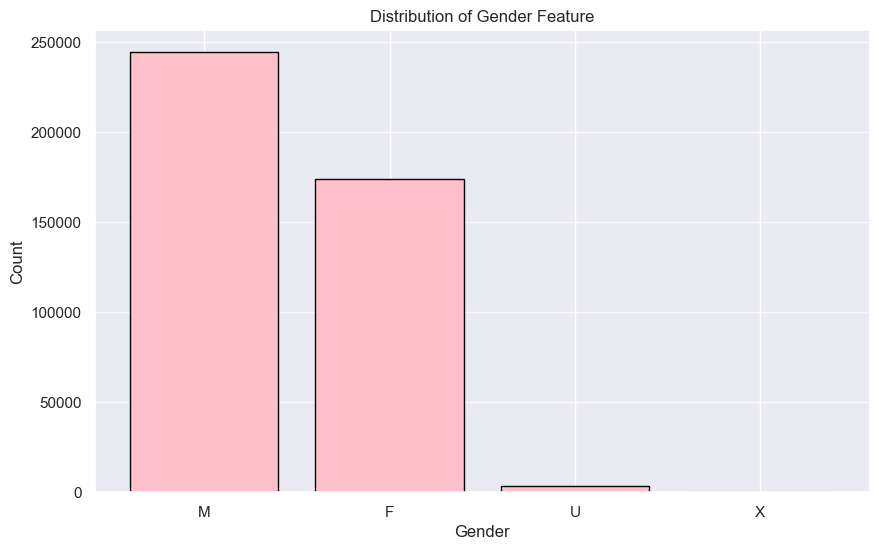

In [59]:
gender_counts = X_train['Gender'].value_counts()
print(gender_counts)

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(gender_counts.index, gender_counts.values, color='pink', edgecolor='black')
plt.title('Distribution of Gender Feature')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [60]:
# Dropping the rows in Gender feature that have U or X as gender values
X_train = X_train[~X_train['Gender'].isin(['U', 'X'])]
X_val = X_val[~X_val['Gender'].isin(['U', 'X'])] 

# remove the same instances from the target variable, because both need to have the same shape for RFE Logistic Regression (for example)
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

In [61]:
X_train['Gender'] = X_train['Gender'].map({'M': 0, 'F': 1})
X_val['Gender'] = X_val['Gender'].map({'M': 0, 'F': 1})

### **2.2.11. Injury Descriptions**

* We have created a function, map_cause_of_injury_description, to make the “cause of injury” descriptions consistent and accurate. This function maps each injury code to its most frequent description (mode). This function generates a dictionary of code-description pairs, in which each unique code in the specified column is paired with its most frequent description. In this way, we can systematically replace codes with their corresponding descriptions, ensuring a standardized representation across the entire dataset.
* Thanks to this, we have mapped several X_train columns - including “Industry code”, “WCIO cause of injury code”, “WCIO nature of injury code” and “WCIO body part code” - to their respective descriptions. The goal is to improve the accuracy of the data, allowing for clearer analysis of patterns and trends. 


In [62]:
def map_cause_of_injury_description(df, code_col, desc_col):

    dict = {}

    for code in df[code_col].unique():
        # get the description of the code
        description = df[df[code_col] == code][desc_col].mode()[0]
        # save the code and description in the dictionary
        dict[code] = description

    # map the industry codes to their descriptions
    return df[code_col].map(dict)

In [63]:
# Use the function to map the descriptions
X_train['Industry Code Description'] = map_cause_of_injury_description(X_train, 'Industry Code', 'Industry Code Description')
X_train['WCIO Cause of Injury Description'] = map_cause_of_injury_description(X_train, 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description')
X_train['WCIO Nature of Injury Description'] = map_cause_of_injury_description(X_train, 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description')
X_train['WCIO Part Of Body Description'] = map_cause_of_injury_description(X_train, 'WCIO Part Of Body Code', 'WCIO Part Of Body Description')

### **2.2.12 Last Check**

In [64]:
#Drop the Accident Date column because we have already extracted the year and month and weekday

X_train.drop(columns=['Accident Date'], inplace=True)
X_val.drop(columns=['Accident Date'], inplace=True)
X_test.drop(columns=['Accident Date'], inplace=True)  # IS THIS CORRECT? DROPPING ON THE TEST SET ?

# Drop the 'Assembly Date' column as we have extracted the year and month

X_train.drop(columns=['Assembly Date'], inplace=True)
X_val.drop(columns=['Assembly Date'], inplace=True)
X_test.drop(columns=['Assembly Date'], inplace=True)  # IS THIS CORRECT? DROPPING ON THE TEST SET ?

In [65]:
X_train.isnull().sum()

Age at Injury                        0
Alternative Dispute Resolution       0
Attorney/Representative              0
Average Weekly Wage                  0
Birth Year                           0
C-2 Date                             0
C-3 Date                             0
Carrier Name                         0
Carrier Type                         0
County of Injury                     0
COVID-19 Indicator                   0
District Name                        0
Gender                               0
Industry Code                        0
Industry Code Description            0
Medical Fee Region                   0
WCIO Cause of Injury Code            0
WCIO Cause of Injury Description     0
WCIO Nature of Injury Code           0
WCIO Nature of Injury Description    0
WCIO Part Of Body Code               0
WCIO Part Of Body Description        0
Zip Code                             0
Number of Dependents                 0
Accident Year                        0
Accident Month           

In [66]:
X_val.isnull().sum()

Age at Injury                           0
Alternative Dispute Resolution          0
Attorney/Representative                 0
Average Weekly Wage                     0
Birth Year                              0
C-2 Date                                0
C-3 Date                                0
Carrier Name                            0
Carrier Type                            0
County of Injury                        0
COVID-19 Indicator                      0
District Name                           0
Gender                                  0
Industry Code                           0
Industry Code Description            1461
Medical Fee Region                      0
WCIO Cause of Injury Code               0
WCIO Cause of Injury Description     2241
WCIO Nature of Injury Code              0
WCIO Nature of Injury Description    2246
WCIO Part Of Body Code                  0
WCIO Part Of Body Description        2463
Zip Code                                0
Number of Dependents              

In [67]:
y_train.isnull().sum()

0

In [68]:
y_val.isnull().sum()

0

THIS NEED TO HAVE THE SAME SHAPE (X_TRAIN WITH Y_TRAIN AND X_VAL WITH Y_VAL) (rows only)

In [69]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((418486, 29), (418486,)), ((101383, 29), (101383,)))

# 3. Exporting the dataset to a new csv file

In [70]:
#Check if the folder 'datasets' exists, if not, create it
import os

if not os.path.exists('datasets'):
    os.makedirs('datasets')

In [71]:
#export to csv 

X_train.to_csv('datasets/preprocessed_train_delivery1.csv')
X_val.to_csv('datasets/preprocessed_val_delivery1.csv')
y_train.to_csv('datasets/preprocessed_y_train_delivery1.csv')
y_val.to_csv('datasets/preprocessed_y_val_delivery1.csv')
X_test.to_csv('datasets/test_delivery1.csv')